C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\887153185.py:114: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\887153185.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


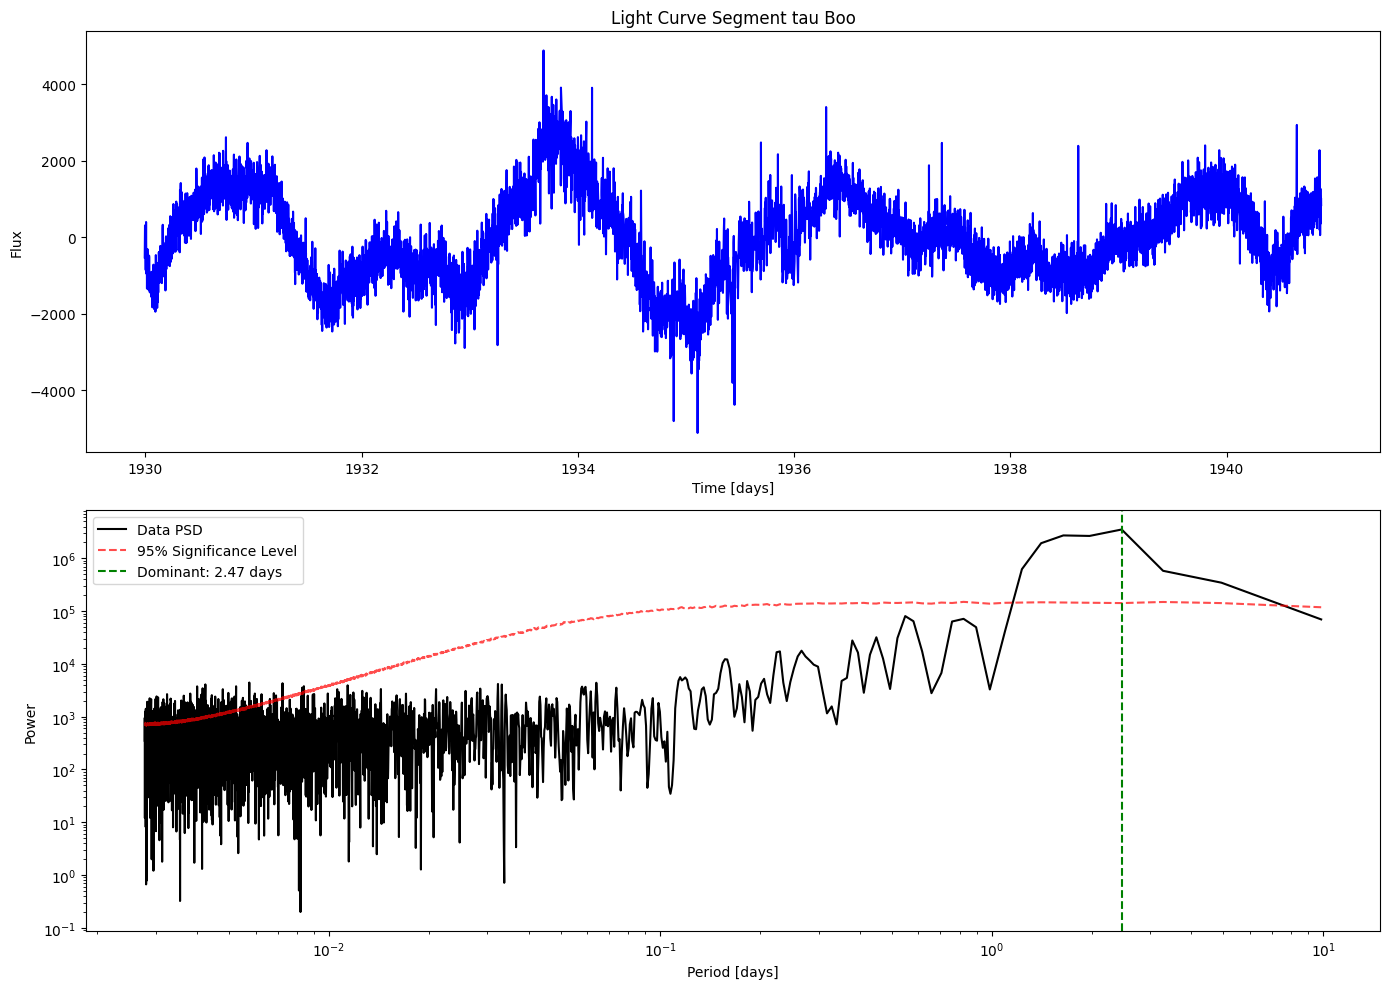

10.882161462777276


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "tau Boo"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 1928
t_end = 1941
mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)
# Integrate the power spectra to get total powers


C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3320\68101693.py:114: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3320\68101693.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


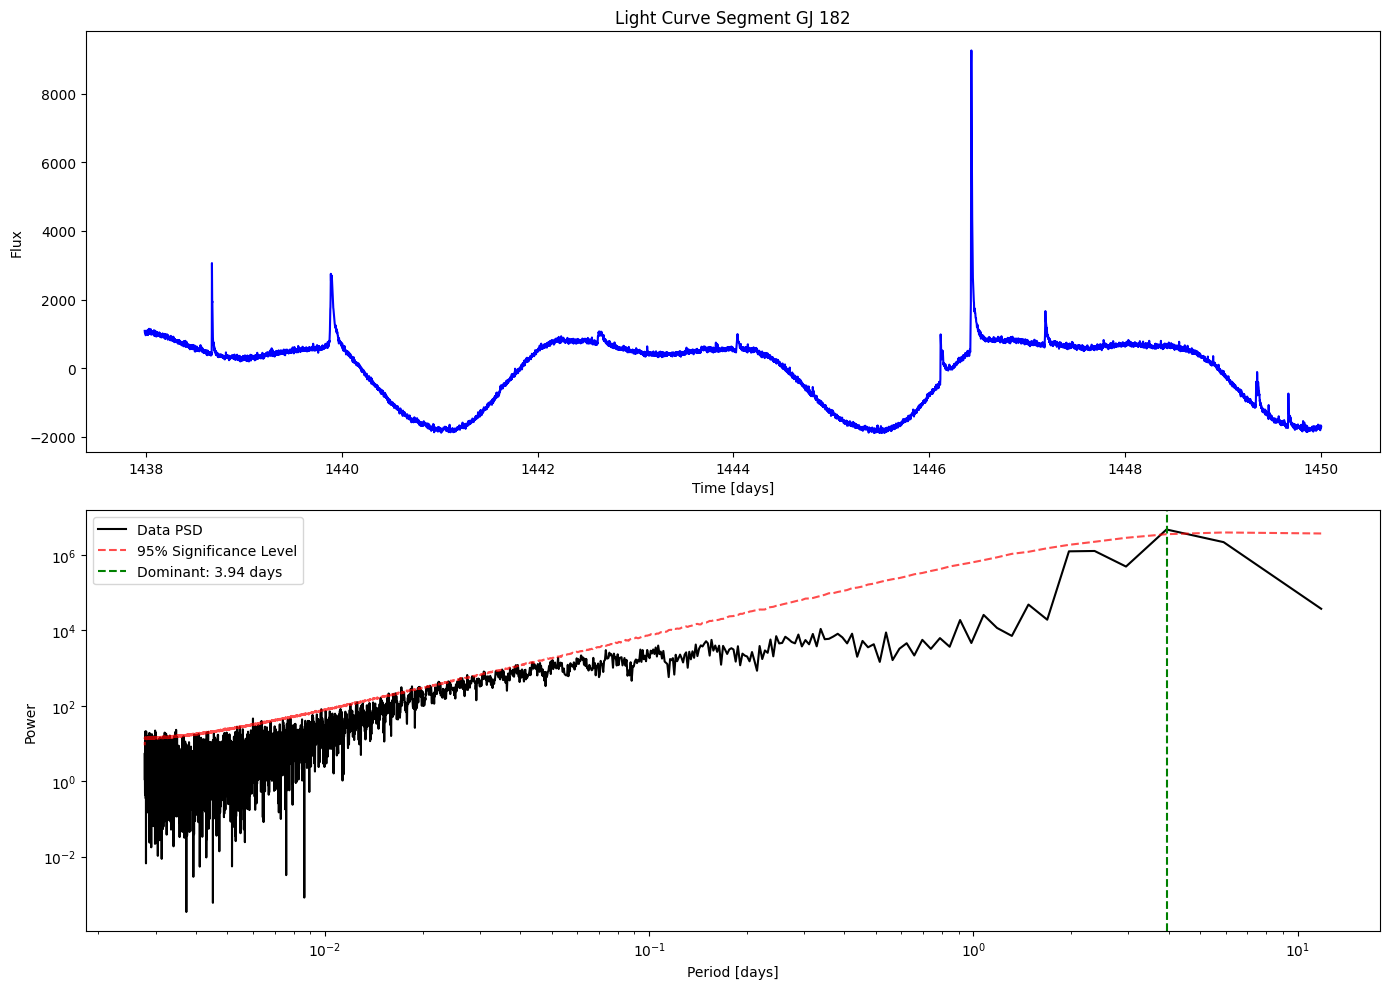

12.009994807728162


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "GJ 182"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 1437
t_end = 1450
mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)

C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 17 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3320\2655663996.py:114: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3320\2655663996.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


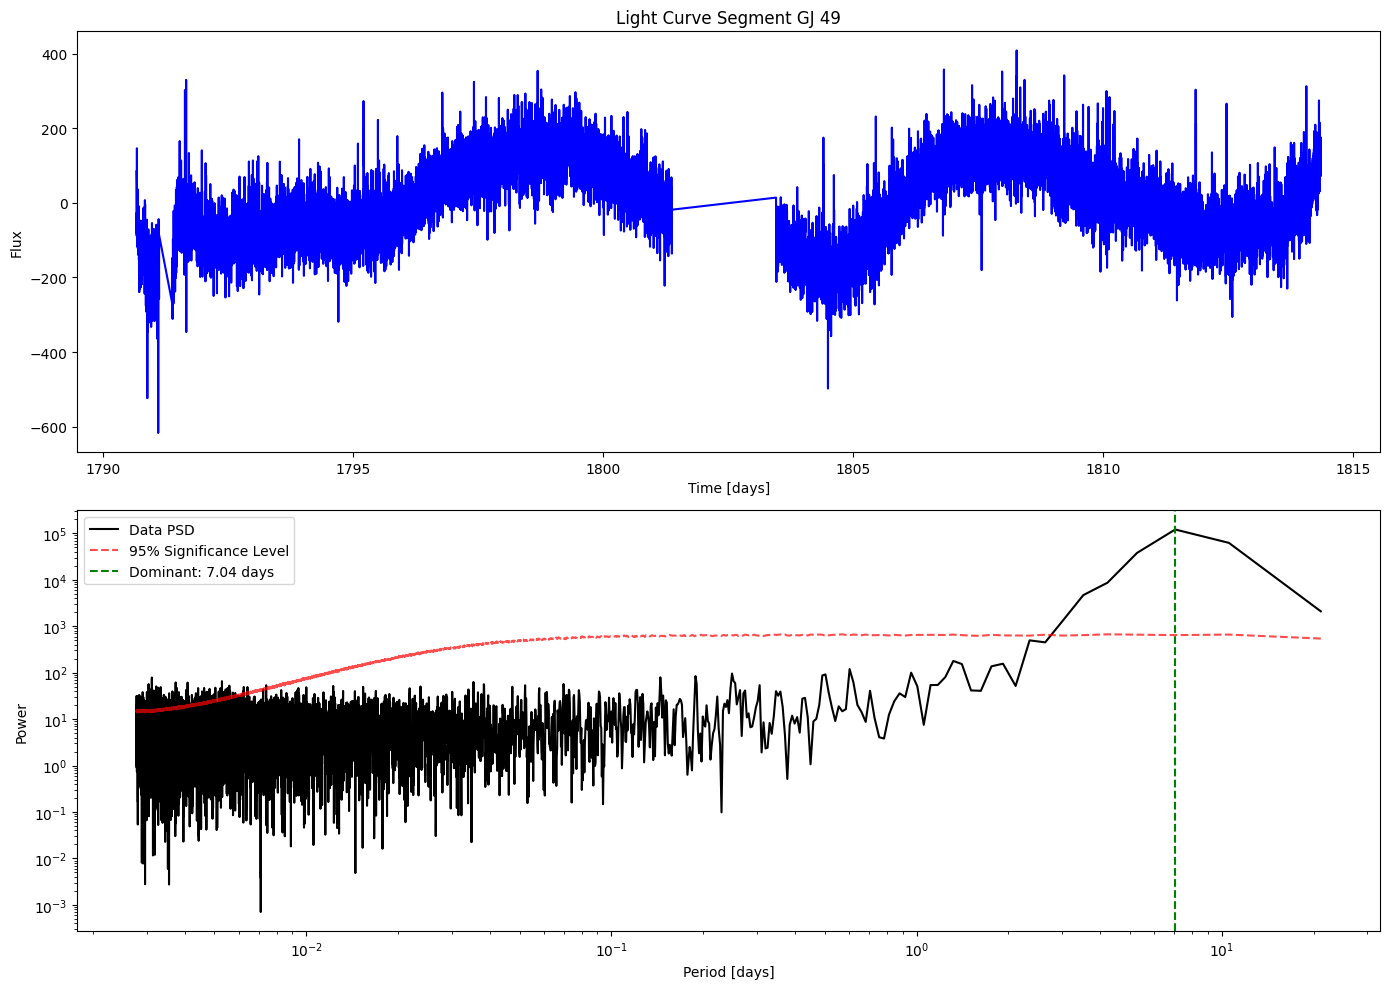

23.68730856141383


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "GJ 49"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 1790
t_end = 1815
mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)

C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 16 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\677557505.py:114: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\677557505.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


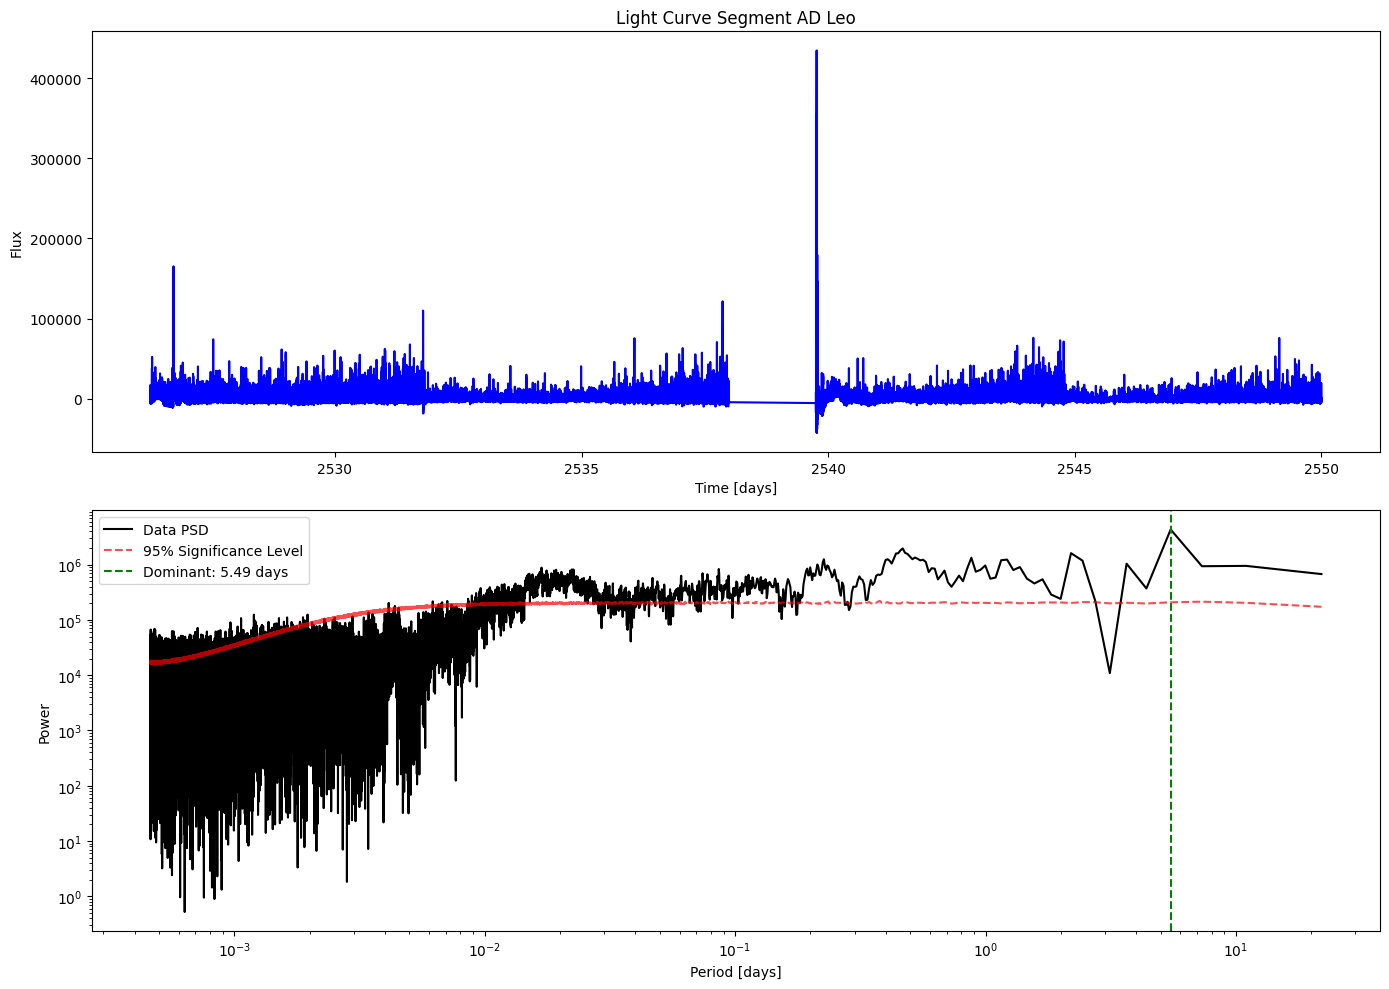

23.739147652232987


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "AD Leo"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 2526
t_end = 2550
mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)

C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 14 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\3900264535.py:114: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\3900264535.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


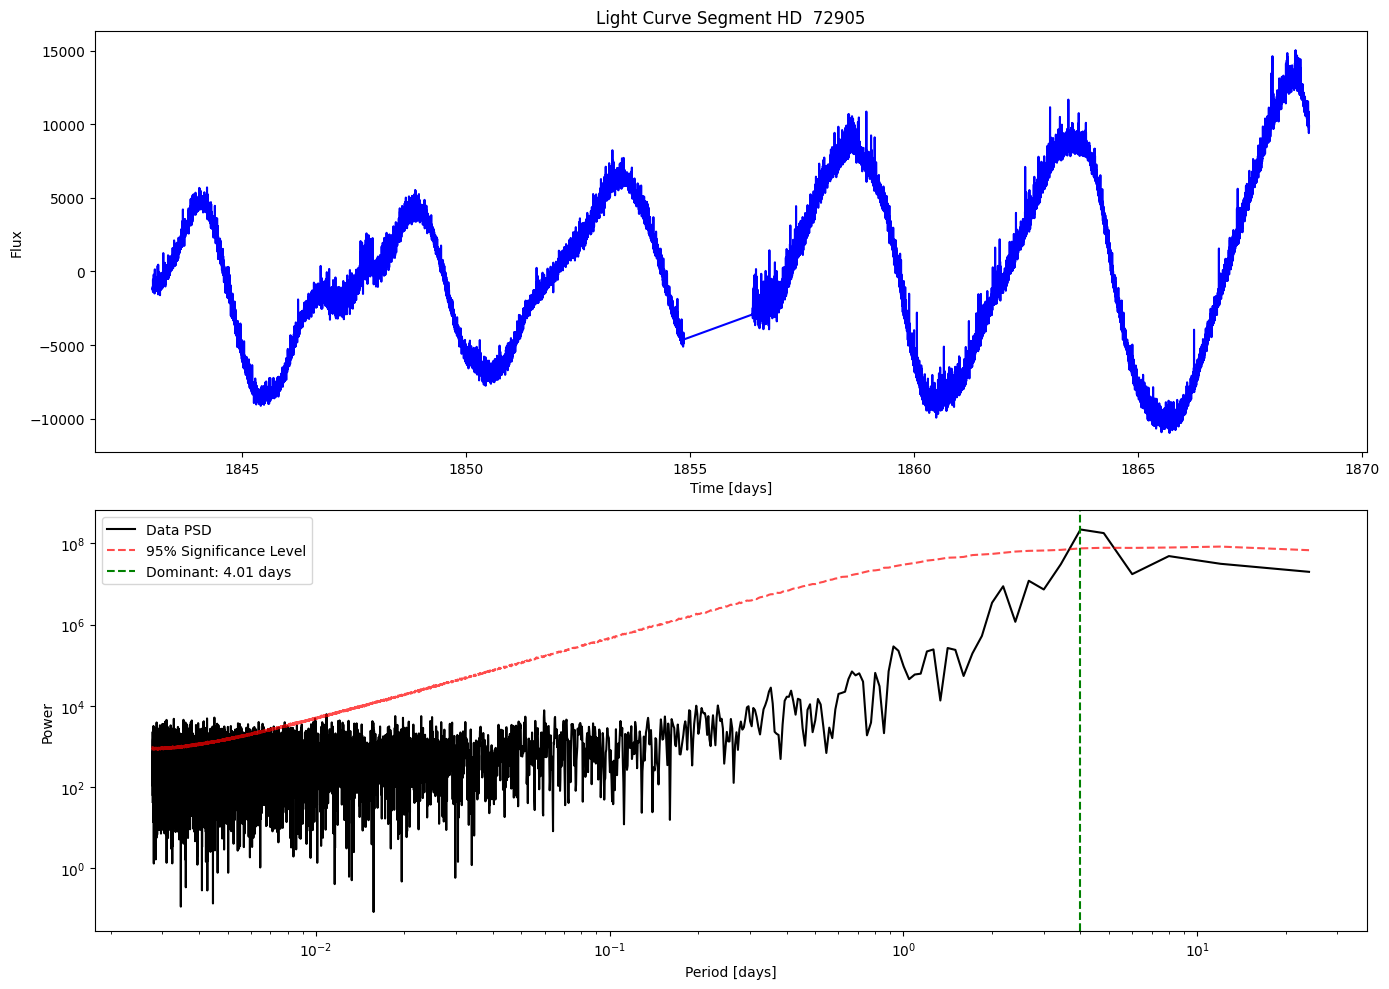

25.82518458515733


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "HD  72905"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 1843
t_end = 1900
mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)


C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 11 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\2426286745.py:114: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\2426286745.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


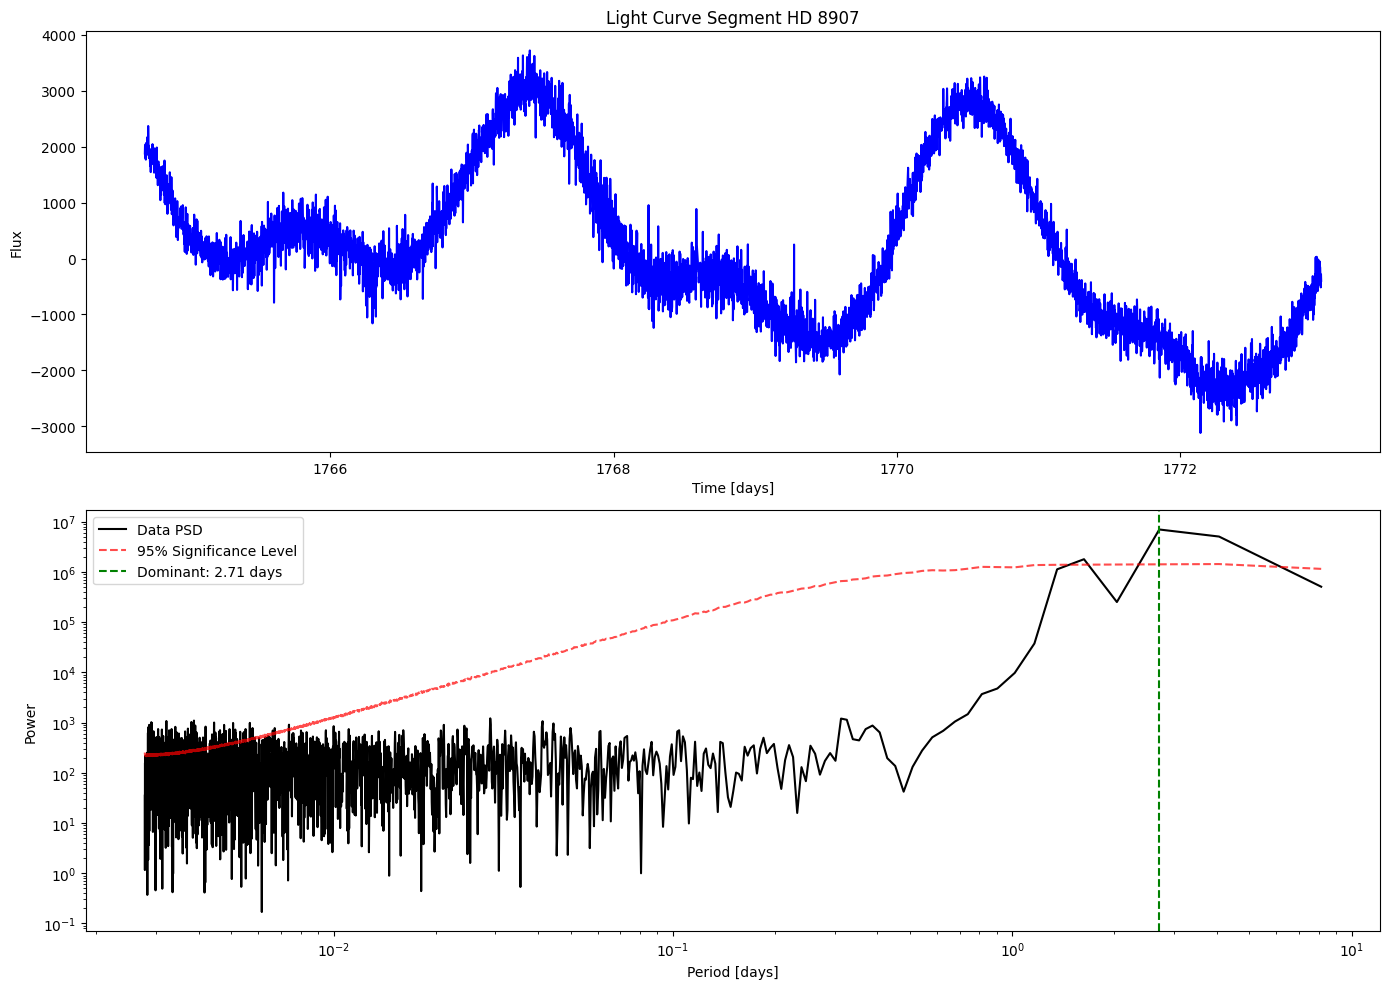

8.309932679672102


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "HD 8907"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 1764
t_end = 1773
mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)

C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


f_real shape: (3610,)
Pxx_den_flux shape: (3610,)
signi_flux shape: (3610,)
signi_flux values: [0.00831127 0.0100077  0.01059706 ... 0.00670541 0.00670156 0.00753169]


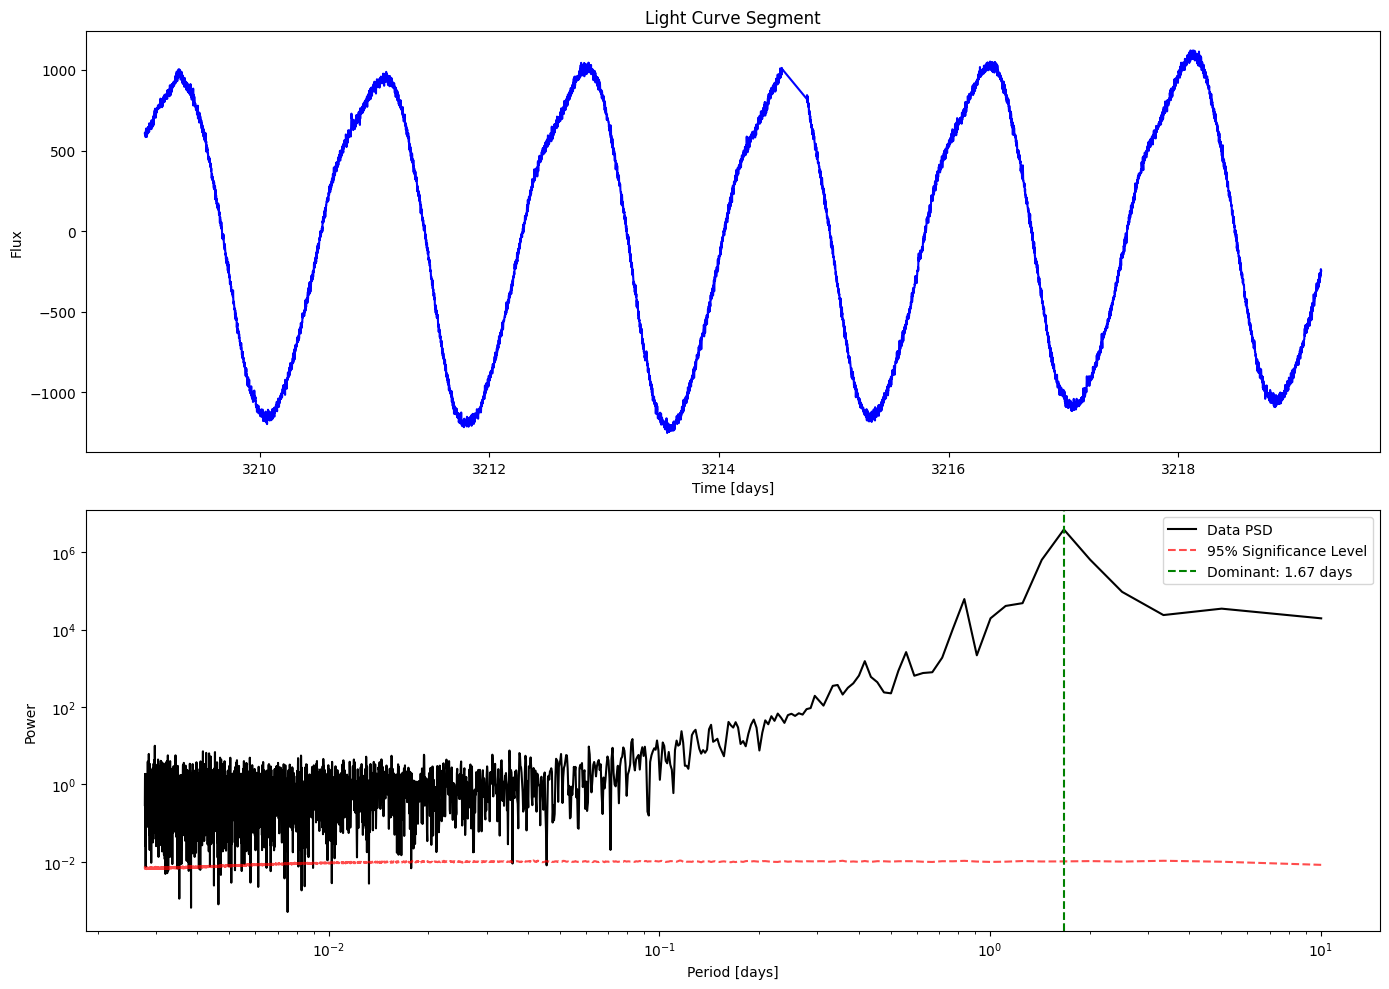

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "2MASS J01562759+1224491"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 3209
t_end = 3219.4
mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def manual_ar1noise(n, c, g=0.9):
    np.random.seed(42)
    X = np.zeros((n, c))
    a = np.sqrt(1 - g**2)
    X[0, :] = np.random.randn(1, c)
    z = np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + a * z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = manual_ar1noise(len(flux), num_real)

surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='bartlett', fs=Fs, nperseg=len(time), average='median')
# Mask to remove f = 0
mask_positive_freq = f_real > 0
f_real = f_real[mask_positive_freq]
Pxx_den_flux = Pxx_den_flux[mask_positive_freq]
signi_flux = signi_flux[mask_positive_freq]

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))
print(f"f_real shape: {f_real.shape}")
print(f"Pxx_den_flux shape: {Pxx_den_flux.shape}")
print(f"signi_flux shape: {signi_flux.shape}")
print(f"signi_flux values: {signi_flux}")

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title('Light Curve Segment')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()


C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\1479788700.py:114: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\1479788700.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


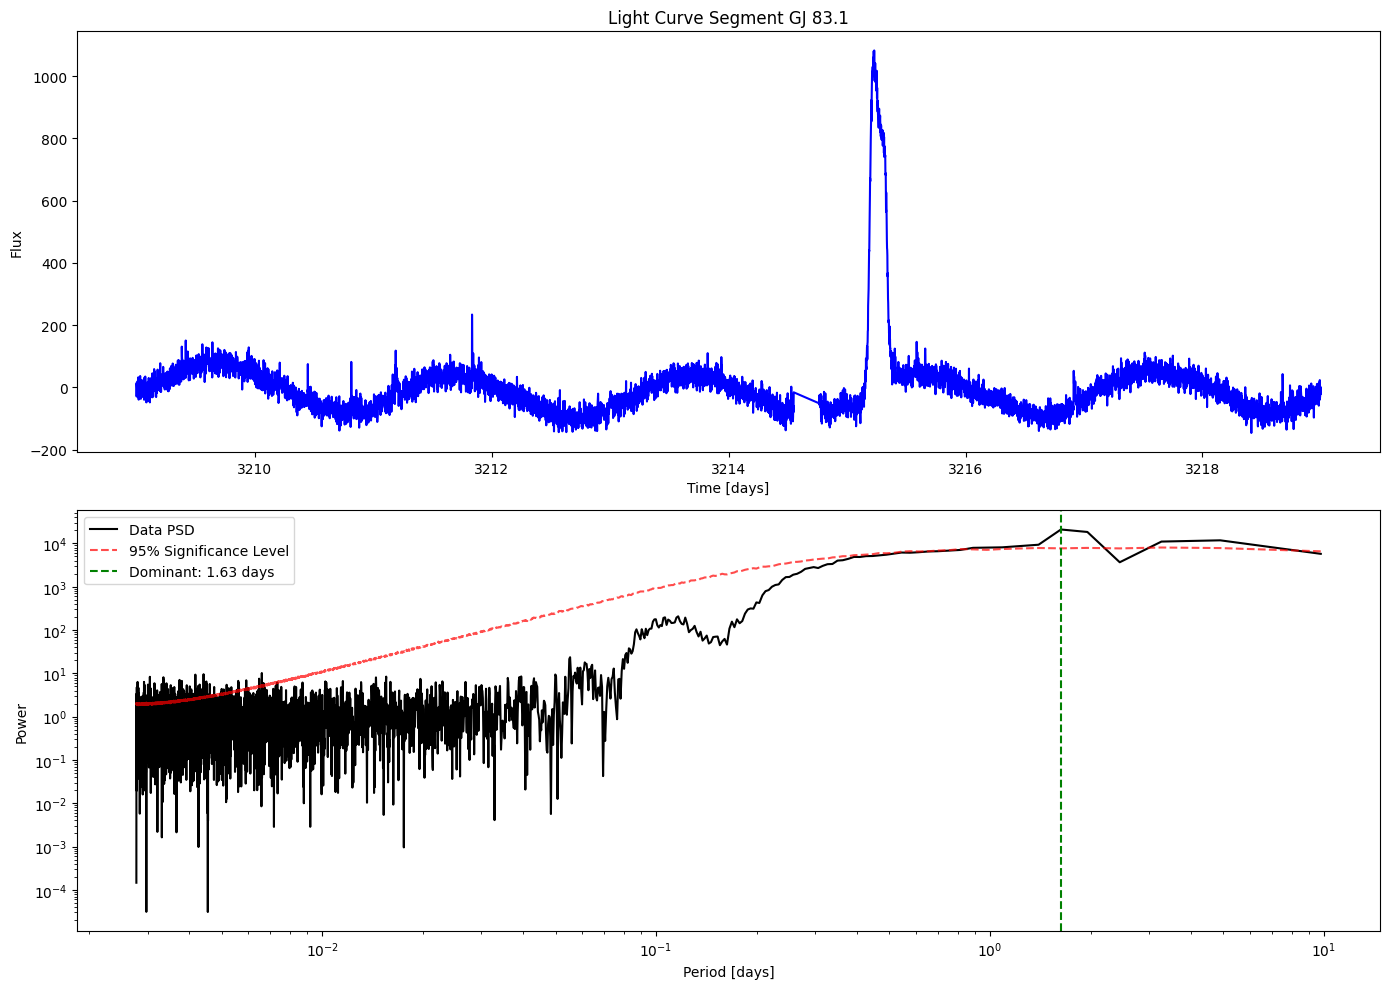

9.99769717471645


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "GJ 83.1"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 3209
t_end = 3219
mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)

C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\574437059.py:114: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\574437059.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


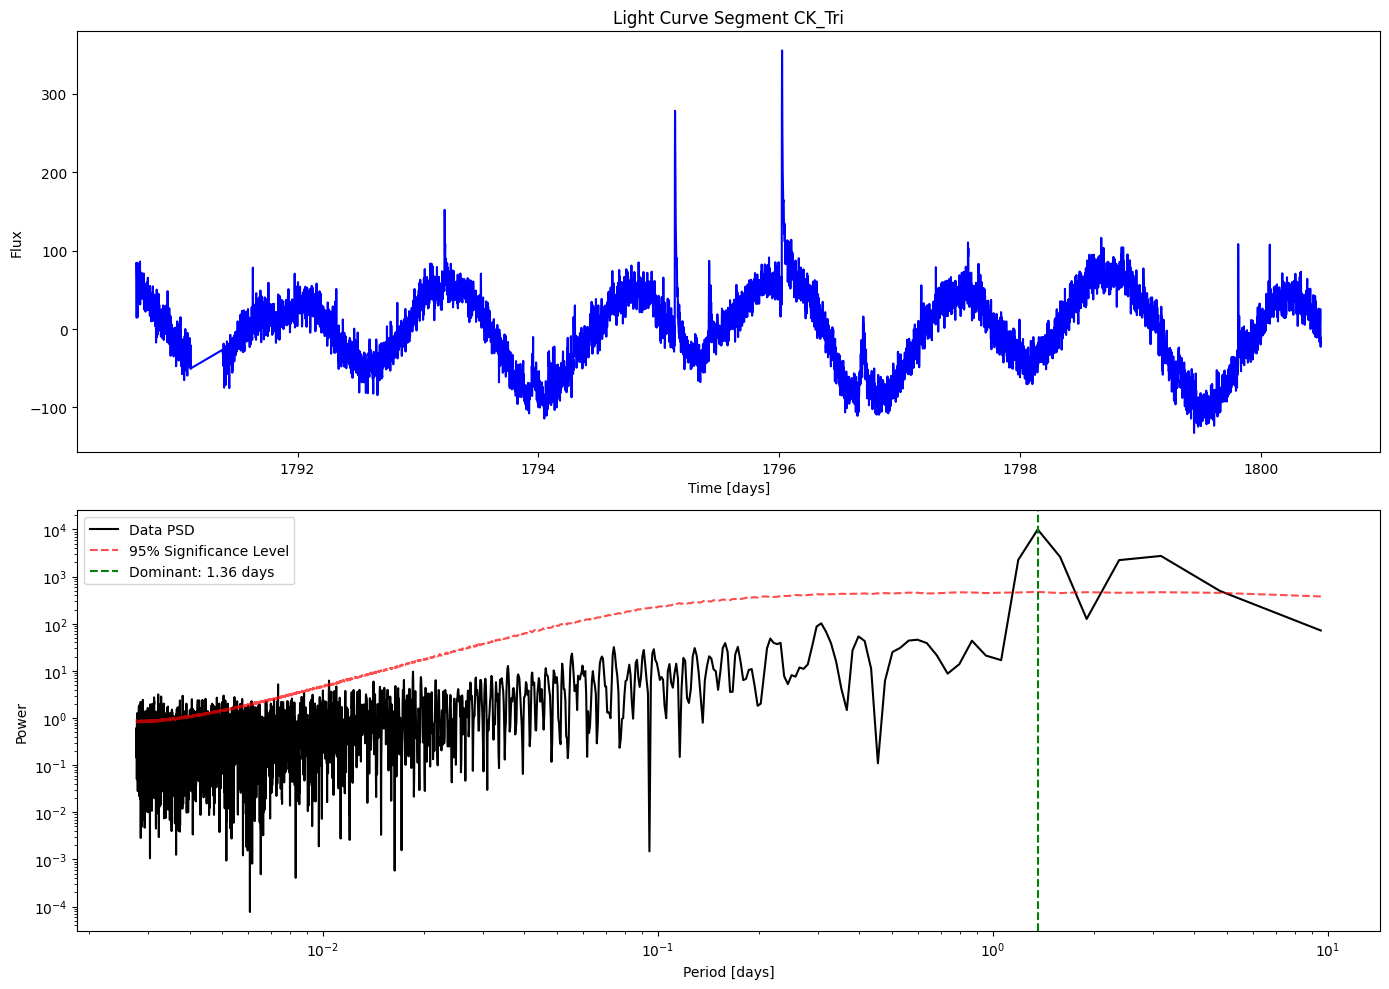

9.837493779556553


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "CK_Tri"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 1790.5
t_end = 1800.5
mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)

C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 8 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\3112533747.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\3112533747.py:116: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


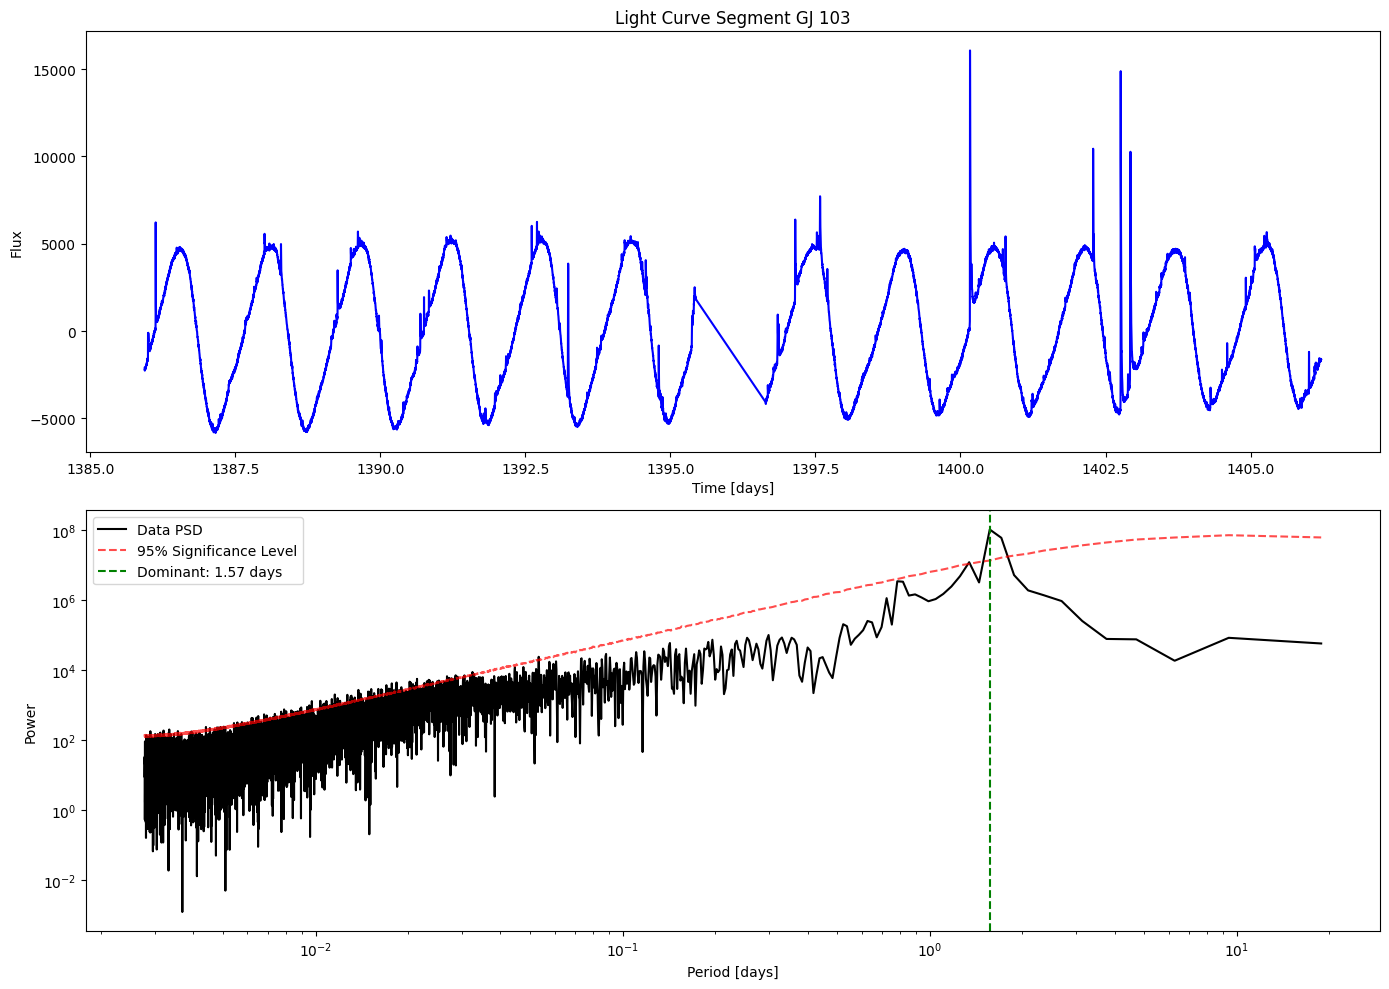

20.277801706195532


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "GJ 103"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 1385.93
t_end = 1406.27

mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)

C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 10 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\934461738.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\934461738.py:116: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


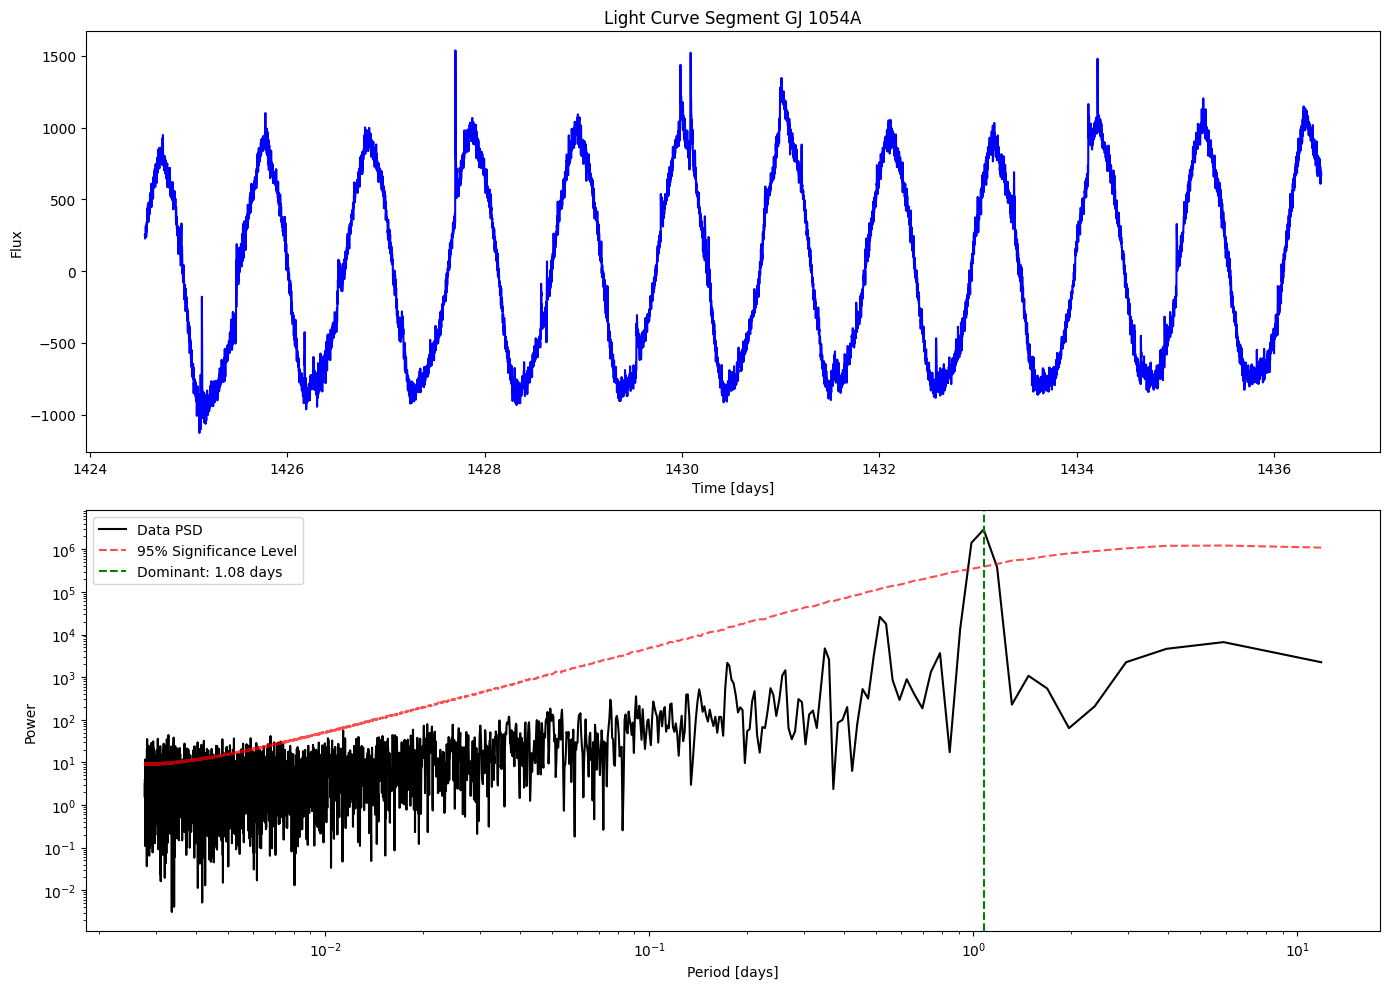

11.915086376421414


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "GJ 1054A"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 1424.5
t_end = 1436.5

mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)

C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 16 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\3403065087.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\3403065087.py:116: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


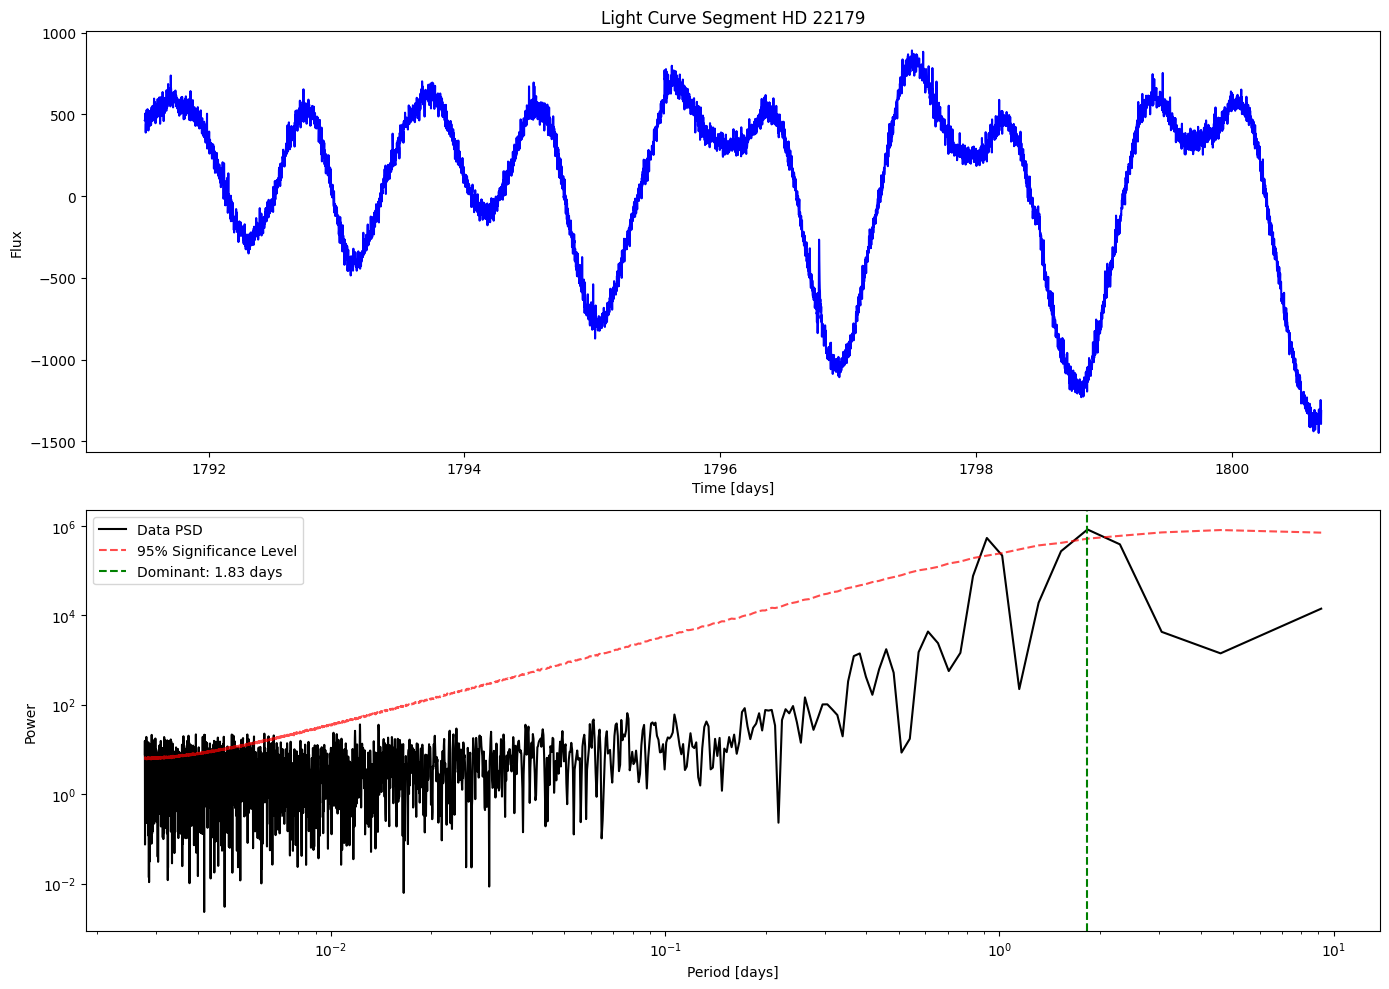

9.198795515537768


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "HD 22179"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 1791.5
t_end = 1801.5

mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)

C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 13 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\33151987.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\33151987.py:116: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


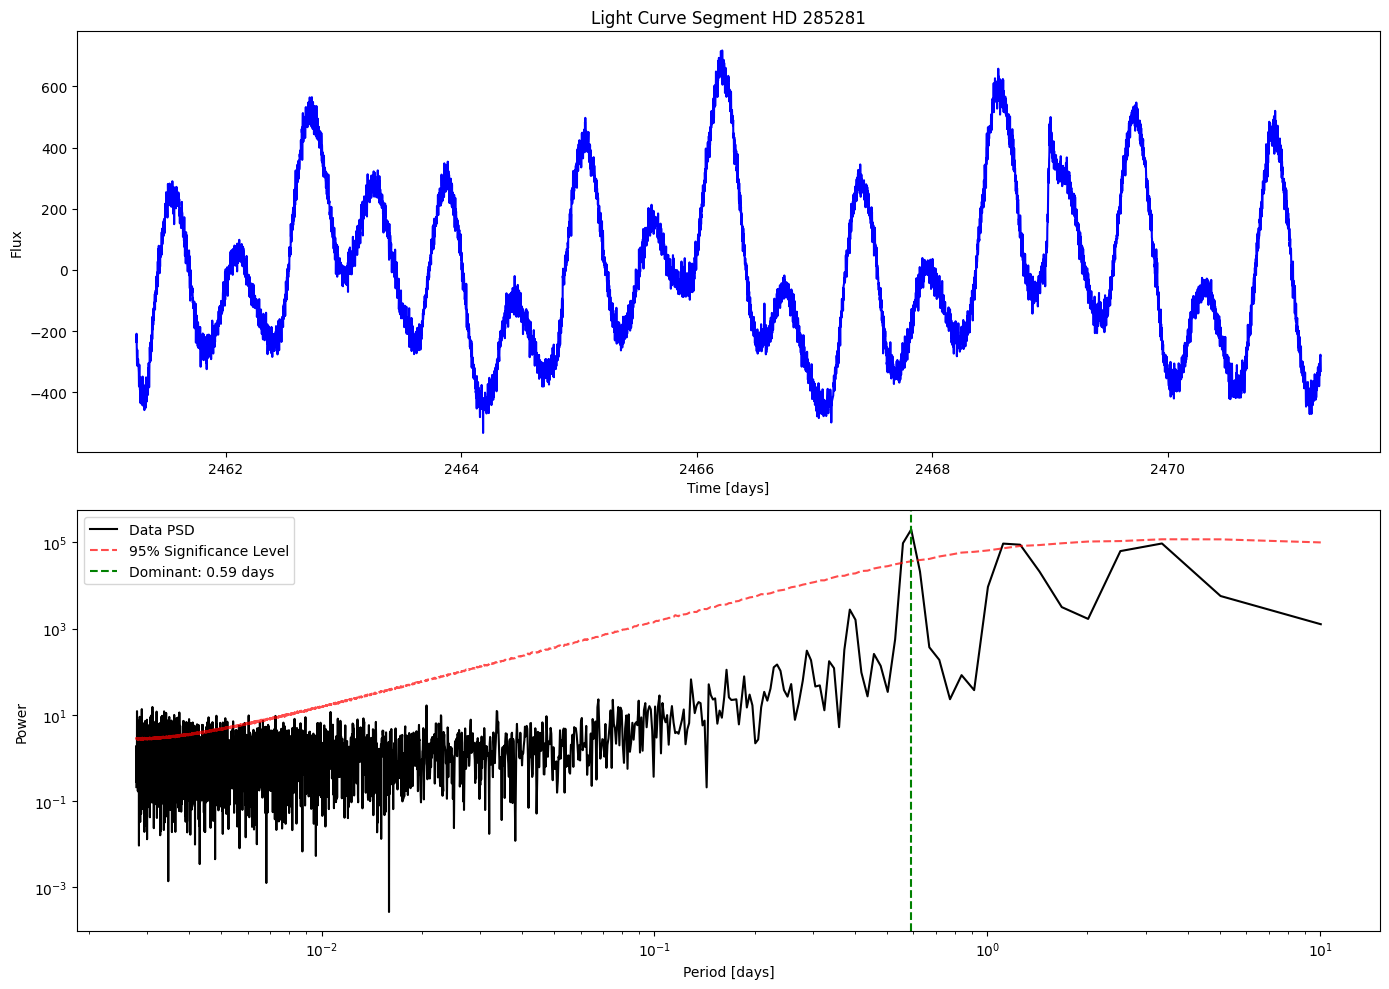

10.059288007884788


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "HD 285281"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 2461
t_end = 2471.3

mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)

C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 14 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\3880875771.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\3880875771.py:116: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


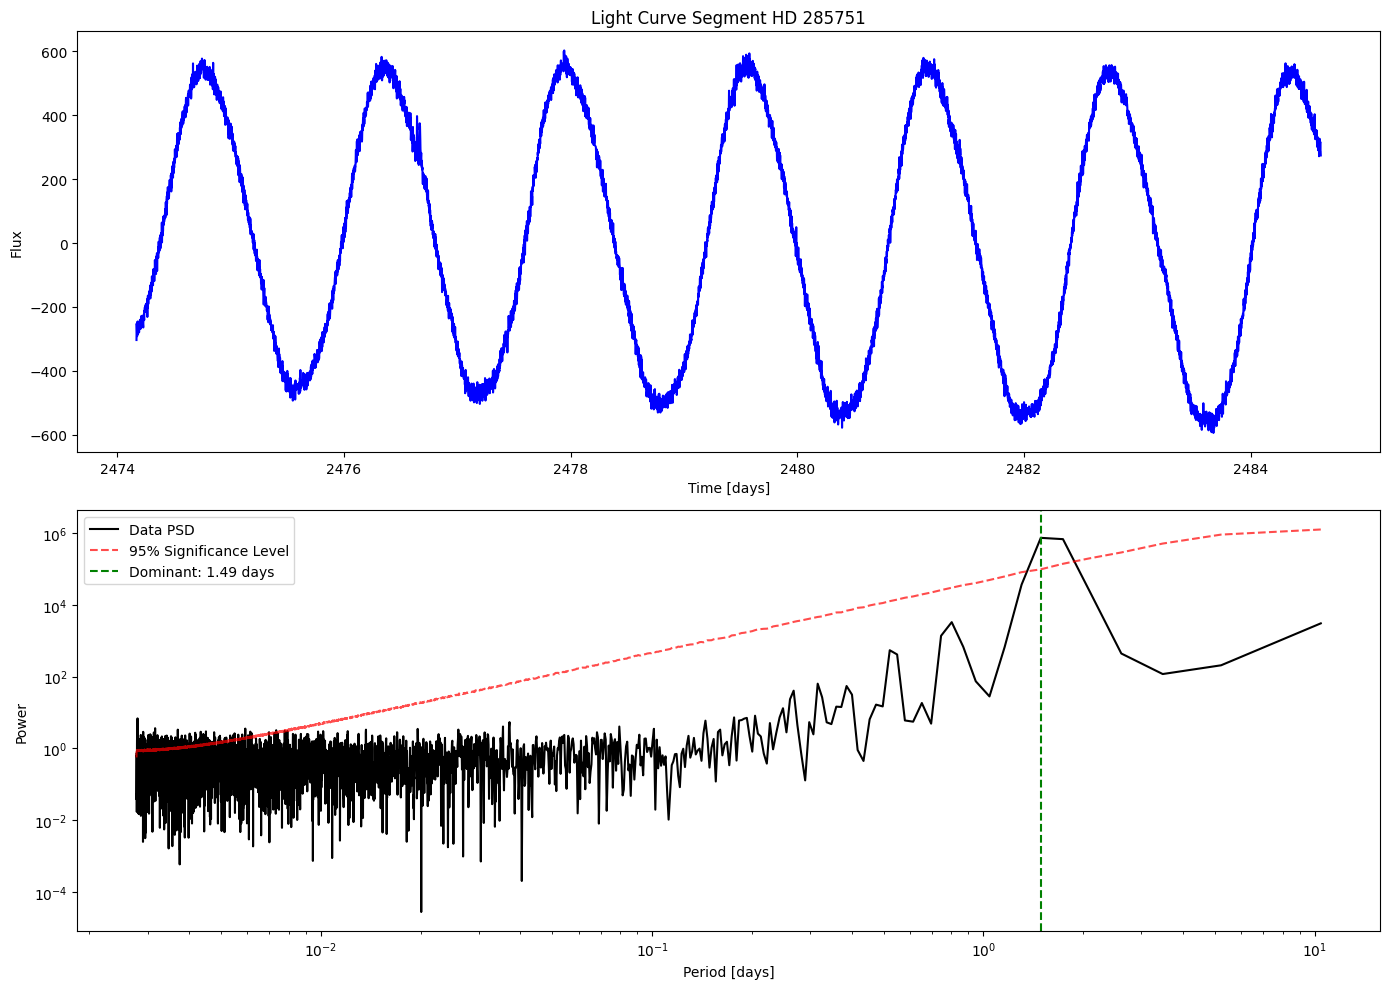

10.449555545102612


In [4]:

import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "HD 285751"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 2474
t_end = 2485

mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)

C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 147 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\2793276790.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\2793276790.py:116: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


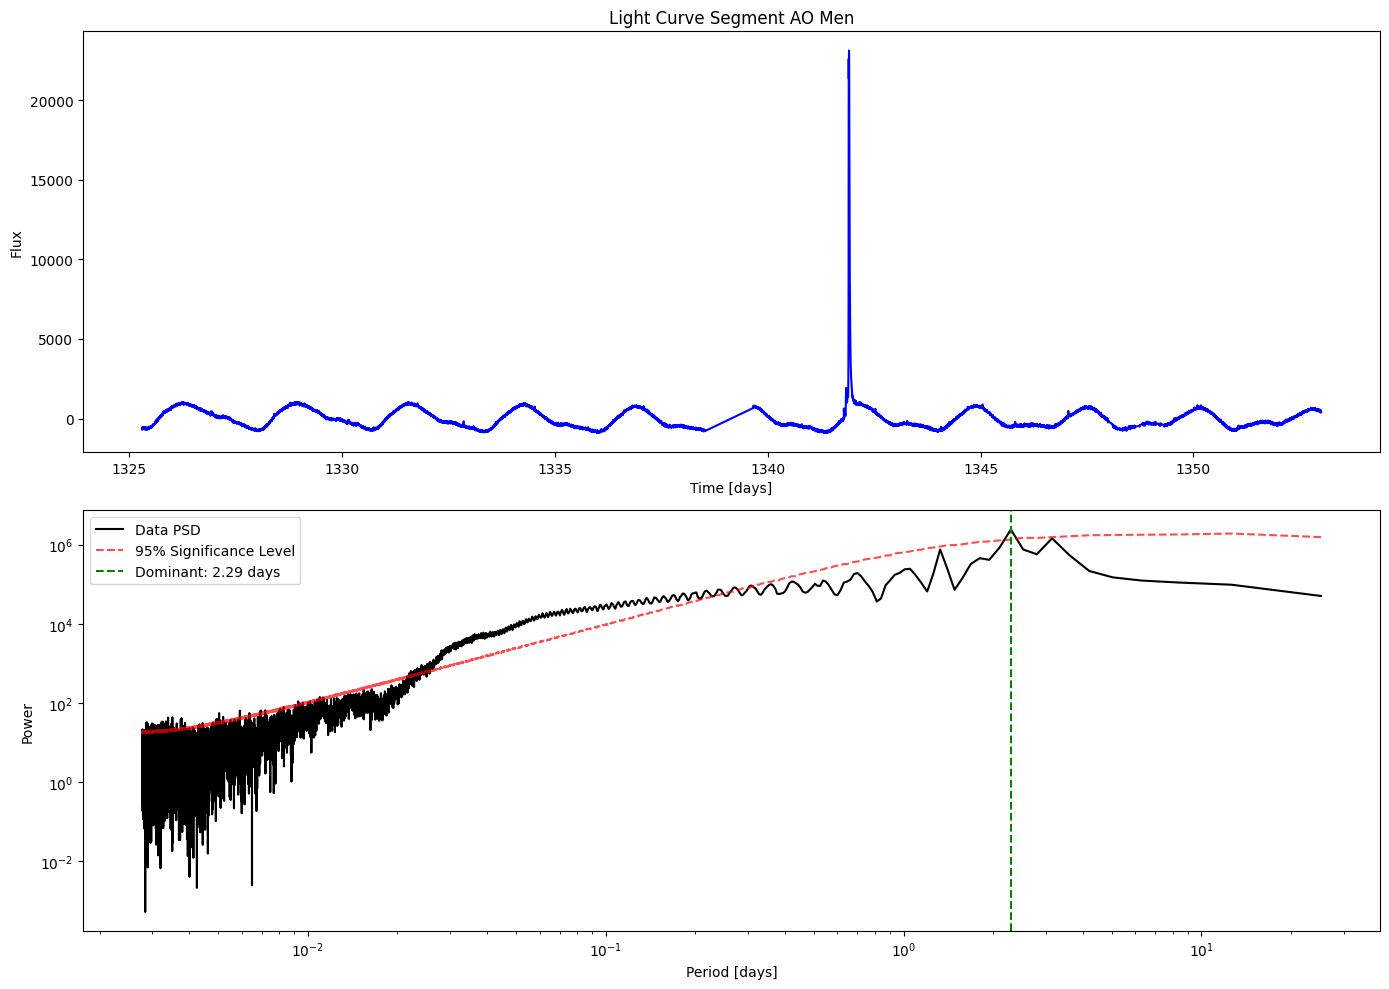

27.702536271403005


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "AO Men"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 1325
t_end = 1353

mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)

C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 7 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\3185959183.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\3185959183.py:116: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


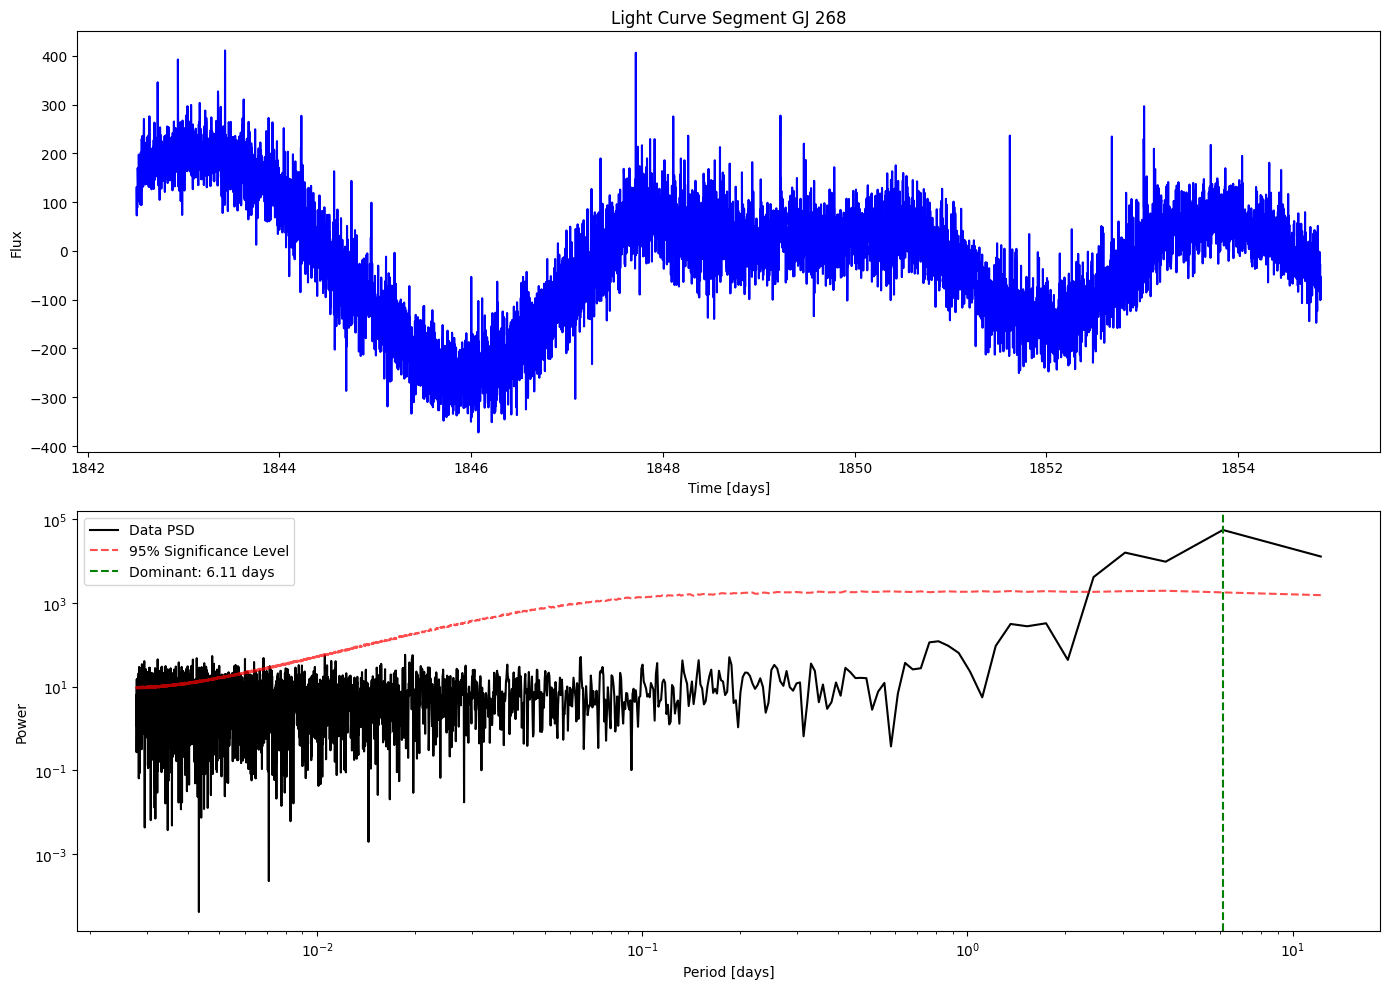

12.35288074384016


In [20]:

import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "GJ 268"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 1842.5
t_end = 1855

mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)


C:\Users\Arghya Chaudhuri\AppData\Roaming\Python\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 17 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\2886621096.py:114: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
C:\Users\Arghya Chaudhuri\AppData\Local\Temp\ipykernel_3272\2886621096.py:115: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')


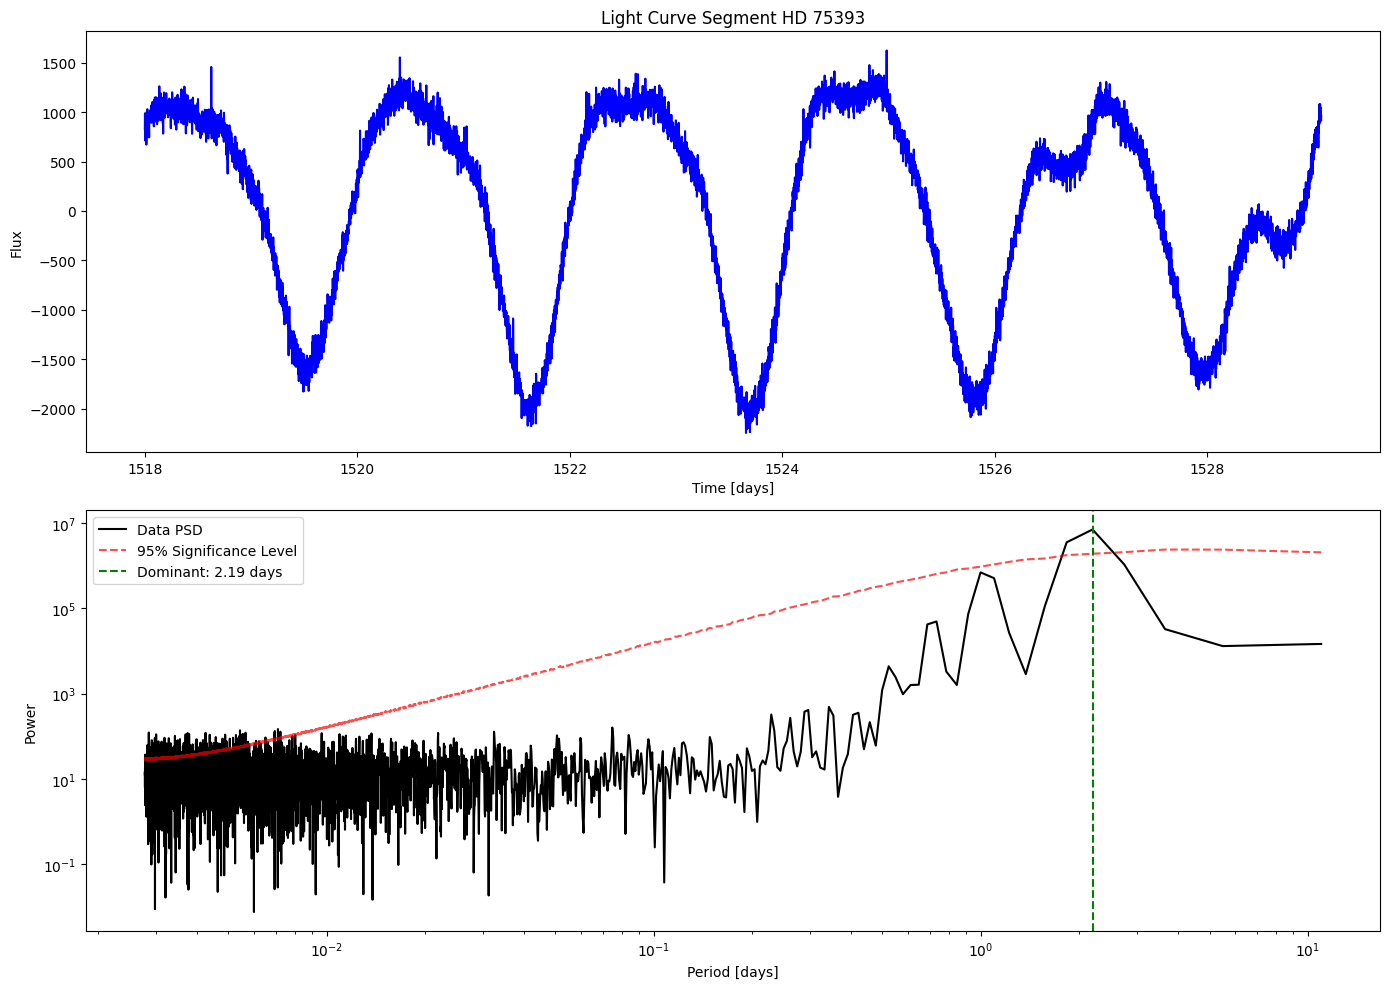

11.069456518298011


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import lightkurve as lk
from astroquery.mast import Catalogs
from statsmodels.tsa.stattools import kpss
import scipy.signal as signal
import statsmodels.api as sm

# Load light curve
hd_id = "HD 75393"
catalog_data = Catalogs.query_object(hd_id, catalog="TIC")
tic_id = catalog_data[0]['ID']
search_result = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS")

if len(search_result) > 0:
    lc = search_result.download()
else:
    raise ValueError("No TESS lightcurve found for target.")

# Preprocess flux and time
time = lc.time.value
flux = lc.flux.value
flux = flux - np.mean(flux)

# Focus on a specific time window
t_start = 1518
t_end = 1529.2
mask = (time >= t_start) & (time <= t_end)
time = time[mask]
flux = flux[mask]

# Remove NaNs
mask = ~np.isnan(flux)
flux = flux[mask]
time = time[mask]

# FFT parameters
N = len(time)
Tobs = time[-1] - time[0]  # Total observation time (days)
dt = np.median(np.diff(time))  # Sampling interval (days)
Fs = 1 / dt  # Sampling frequency (samples per day)

# FFT of flux
fy = fft.fft(flux)
df = 1 / Tobs  # Frequency resolution
f = np.arange(0, N // 2) * df  # Frequency array
psd = (np.abs(fy[:N // 2]) * 2 / N)**2
psd = psd / (2 * df)  # Normalize PSD

#-------------------------------------------------
# Red-noise surrogate generation
#-------------------------------------------------
def ar1(x):
    x = np.array(x).flatten()
    N = len(x)
    m = np.mean(x)
    x = x - m
    c0 = np.dot(x, x) / N
    c1 = np.dot(x[:-1], x[1:]) / (N - 1)
    B = -c1*N - c0*N**2 - 2*c0 + 2*c1 - c1*N**2 + c0*N
    A = c0*N**2
    C = N*(c0+c1*N-c1)
    D = B**2 - 4*A*C
    if D > 0:
        g = (-B - np.sqrt(D)) / (2*A)
    else:
        g = np.nan
    mu2 = -1/N + (2/N**2)*((N - g**N)/(1 - g) - g*(1 - g**(N-1))/(1 - g))
    c0t = c0 / (1 - mu2)
    a = np.sqrt((1 - g**2) * c0t)
    return g, a, mu2

def ar1noise(x, c):
    n = len(x)
    g, a, mu2 = ar1(x)
    np.random.seed(42)
    X = np.zeros((n, c))
    X[0, :] = np.sqrt(a**2 / (1 - g**2)) * np.random.randn(1, c)
    z = a * np.random.randn(n, c)
    for i in range(1, n):
        X[i, :] = g * X[i-1, :] + z[i, :]
    X = X - np.mean(X, axis=0)
    return X

# Generate surrogates
num_real = 5000
surrogate = ar1noise(flux, num_real)
surrogate_psd = []

for i in range(num_real):
    f_sur, Pxx_den = signal.welch(x=surrogate[:,i], window='hann', fs=Fs, nperseg=len(time), average='median')
    surrogate_psd.append(Pxx_den)

# 95% threshold
prctile = 95
signi_flux = np.percentile(np.array(surrogate_psd), prctile, axis=0)

# Real data PSD
f_real, Pxx_den_flux = signal.welch(x=flux, window='hann', fs=Fs, nperseg=len(time), average='median')

#-------------------------------------------------
# Plot everything
#-------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Time domain plot
ax[0].plot(time, flux, color='blue')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux')
ax[0].set_title(f'Light Curve Segment {hd_id}')

# Fourier domain plot (Power spectrum)
ax[1].loglog(1/f_real, Pxx_den_flux, color='black', label='Data PSD')
ax[1].loglog(1/f_real, signi_flux, color='red', linestyle='--', alpha=0.7, label=f'{prctile}% Significance Level')

# Dominant peak annotation
dominant_freq_idx = np.argmax(Pxx_den_flux)
dominant_freq = f_real[dominant_freq_idx]
dominant_period = 1 / dominant_freq
ax[1].axvline(x=dominant_period, color='green', linestyle='--', lw=1.5, label=f'Dominant: {dominant_period:.2f} days')

ax[1].set_xlabel('Period [days]')
ax[1].set_ylabel('Power')
ax[1].legend()
#ax[1].invert_xaxis()  # period decreasing to right

plt.tight_layout()
plt.show()
print(Tobs)